In [1]:
import datetime
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
conn = sqlite3.connect("../itp_gen.db")
cur = conn.cursor()

meter_id = "1ESY1312000111"
date = datetime.date.fromisoformat("2018-11-07")
next_date = date + datetime.timedelta(days=1)

In [4]:
def f_pd(counter):
    pd_query = "SELECT datum_zeit, obis_180, obis_170 FROM zaehlwerte WHERE zaehler_id = ? " \
               "ORDER BY datum_zeit"
    pd_df = pd.read_sql(pd_query, conn, params=[meter_id], parse_dates=['datum_zeit'])
    pd_df = pd_df.set_index('datum_zeit')
    pd_df['diff'] = pd_df['obis_180'].diff().shift(periods=-1)
    pd_day = pd.DataFrame()
    for i in range(counter):
        pd_day = pd_df[date.strftime('%Y-%m-%d')].resample('15T').agg({'obis_180': 'first', 'diff': 'sum'})
    return pd_day

def f_sql(counter):
    sql_query = "SELECT datum_zeit, obis_180, obis_170 FROM zaehlwerte WHERE datum_zeit BETWEEN ? AND ? " \
                "AND STRFTIME('%M', datum_zeit) % 15 = 0 AND zaehler_id = ? ORDER BY datum_zeit"
    sql_df = pd.DataFrame()
    for i in range(counter):
        sql_df = pd.read_sql(sql_query, conn, params=[date, next_date.strftime('%Y-%m-%d %H:%M:%S'), meter_id], parse_dates=['datum_zeit'])
        sql_df = sql_df.set_index('datum_zeit')
        sql_df['diff'] = sql_df['obis_180'].diff().shift(periods=-1)
        sql_df = sql_df.dropna()
    return sql_df

In [5]:
s = pd.Series(f_pd(1)['diff'] == f_sql(1)['diff'])
mask = s.values != True
pd.Series(s.values[mask], s.index[mask])

Series([], Freq: 15T, dtype: bool)

In [9]:
%%capture
df_times = []
for i in range(30):
    res = %timeit -o f_pd(i)
    df_times.append(res.average)

In [10]:
%%capture
sql_times = []
for i in range(30):
    res = %timeit -o f_sql(i)
    sql_times.append(res.average)

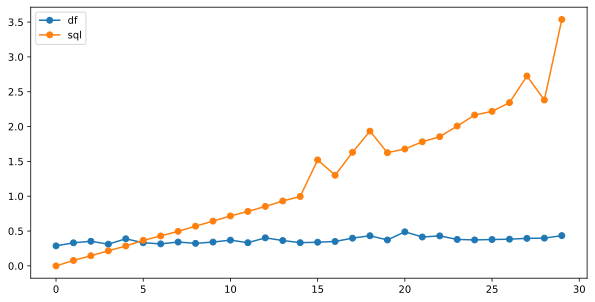

In [11]:
times = pd.DataFrame({'df': df_times, 'sql': sql_times})
times.plot(marker='o')